## **Project. Neural Networks for Classification**
- Student ID: 

- Full name: 

### **Import Libraries**

In [7]:
import numpy as np
print(np.__version__)

2.0.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import datasets
import time

#### **1.1 Data collection**

In [8]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
X_train.shape

(50000, 32, 32, 3)

In [9]:
y_train = y_train.reshape(-1,)
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [10]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#### **1.2 Data Nomalization**
It can be observed that the value of each pixel in an image is in the range of 0-255. We need to normalize it to the range (0, 1).

In [11]:
def nomalize(X):
    return X/255

X_train = nomalize(X_train)
X_test = nomalize(X_test)

In [12]:
(X_train.min(), X_train.max())

(0.0, 1.0)


Now our data has been normalized to the range (0, 1).

#### **1.3 Flatten**

In [13]:
X_train.shape

(50000, 32, 32, 3)


We can see that our image has dimensions of 32x32x3, representing an image with a size of 32x32 and 3 RGB channels. Now, we need to flatten it.

In [14]:
def flatten_images(images):
    return images.reshape(images.shape[0], -1)  # Flatten each image

X_train = flatten_images(X_train)
X_test = flatten_images(X_test)

In [16]:
X_train[0].shape

(3072,)

Now, our image data has been flattened, with the size of a single input being (32x32x3 = 3072)

#### **1.4 Encoding**

In [17]:
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)


Our output will consist of labels ranging from 0 to 9, corresponding to the classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

In [18]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]  # Convert to one-hot encoded array

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

In [19]:
y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])
y_test.shape

(10000, 10)

In [20]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])


After encoding, each output will be a binary vector of length 10. The position with a value of 1 corresponds to the label. For example, if the 4th position has a value of 1, the label is 4, which corresponds to *deer*.

### **2. Model Design**

#### **2.1. Number of layers: Decide on how many hidden layers the MLP will have.**
"How to Configure the Number of Layers and Nodes in a Neural Network" : https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

- In fact, there is a theoretical finding by Lippmann in the 1987 paper “An introduction to computing with neural nets” that shows that an MLP with two hidden layers is sufficient for creating classification regions of any desired shape. This is instructive, although it should be noted that no indication of how many nodes to use in each layer or how to learn the weights is given. 

- A single-layer neural network can only be used to represent linearly separable functions. This means very simple problems where, say, the two classes in a classification problem can be neatly separated by a line. If your problem is relatively simple, perhaps a single layer network would be sufficient. Most problems that we are interested in solving are not linearly separable. As in our case, we need to classify up to 10 layers, which is very difficult to do, if there is only one hidden layer in our neural network.

$\implies$ So we can choose the `number of hidden layers `for MLP as 3, it will be satisfied in this case.

#### **2.2. Number of neurons per layer: Decide on the number of neurons in each layer.**
"How to decide Number of Neurons In Input and Output Layers and how many Hidden Layers and how many neurons are required in Hidden Layers?" https://www.kaggle.com/discussions/general/321114

When it comes to the hidden layers, the main concerns are how many hidden layers and how many neurons are required? There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

- The number of hidden neurons should be between the size of the input layer and the size of the output layer.
- The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
- The number of hidden neurons should be less than twice the size of the input layer.

In our case, the input layer is much larger than the output layer because the input layer size is 3072 neurons and the output layer size is 10 neurons representing the 10 classes that we need to classify, so we cannot use rule 1, in this case we will use rule 2

Above we have a multi-neuron network design with 3 hidden layers, with the first layer we will choose 512 neurons and the second layer is 256 neurons and 128 neurons for the third layer. This creates a decreasing "pyramid" structure, helping the network learn properties in the data. Thus, the number of neurons for each hidden layer of ours has satisfied rule 2 (512 + 256 + 128 = 896 < 3072*2/3 + 10 = 2058).

$\implies$ So we can choose the `number of neurons in each layers` (512,256,128).

#### **2.3. Activation functions: Sigmoid, ReLU and Softmax (for multi-class classification).**
"Why ReLU Is Better Than the Other Activation Functions?" https://www.geeksforgeeks.org/why-relu-is-better-than-the-other-activation-functions/

"why we cannot use the RELU activation function in the output layer?" https://www.linkedin.com/pulse/why-we-cannot-use-relu-activation-function-output-layer-dwivedi/

"Can dropout and batch normalization be applied to convolution layers" https://datascience.stackexchange.com/questions/25722/can-dropout-and-batch-normalization-be-applied-to-convolution-layers
- ReLU stands out as a preferred activation function in deep learning due to its simplicity, non-saturating nature, sparsity-inducing properties, reduced risk of gradient explosion, faster convergence, and empirical success in various applications. ReLU is a powerful activation function for hidden layers but is not suitable for the output layer. This is because it only produces positive values and is not a smooth function, which can lead to unstable predictions. So we use the ReLU activation function for the hidden layer.

The formula for the `ReLU (Rectified Linear Unit)` activation function is:
$$
\text{ReLU}(x) = \max(0, x)
$$

In piecewise form:

$$
\text{ReLU}(x) = 
\begin{cases} 
x & \text{if } x > 0 \\
0 & \text{if } x \leq 0
\end{cases}
$$
- Softmax for the output layer to handle multi-class classification (in this case we have 10 class at the output so we should use the Softmax like the HW2-HW3 that we have been done in this course to classify the image of number from 0 to 9).

The `Softmax` activation function is defined as:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$

Where:
- $ z_i $ is the i-th input to the softmax function.
-  C  is the total number of classes.
- $ e^{z_i} $ is the exponential of $ z_i $.

$\implies$ So we can choose the `ReLU activation function` for the hidden layer and `Softmax` for the output layer.
#### **2.4. Dropout or batch normalization: If needed, incorporate dropout or batch normalization to prevent overfitting and to speed up training phase**
"Dropout and Batch Normalization" https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization

"What are the best practices for avoiding dropout in deep learning?" https://www.linkedin.com/advice/3/what-best-practices-avoiding-dropout-deep-learning-86fwe

"Can dropout and batch normalization be applied to convolution layers" https://datascience.stackexchange.com/questions/25722/can-dropout-and-batch-normalization-be-applied-to-convolution-layers

**`Dropout`**
- The first of these is the "dropout layer", which can help correct overfitting.
- This is the idea behind dropout. To break up these conspiracies, we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.
- The most effective way to avoid excessive dropout is to start with a reasonable initial dropout ratio such as 0.5 and then fine-tune with validation data. I typically find that a ratio of 0.3-0.5 works well for most hidden layers

**`Batch Normalization`**
- Most often, batchnorm is added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck".
- The idea of ​​batch normalization, Batch Normalization normalizes the output of the previous layer (before entering the activation function) by reducing mean to 0 and scale variance to 1 and applying additional scale and shift parameters to maintain flexibility. of the model.

**Normalize the input (from the previous layer):**

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

Where:  
- $ x_i $: Input from the previous layer.  
- $\mu_B $: Mean of the current batch.  
- $ \sigma_B^2 $: Variance of the current batch.  
- $ \epsilon $: A small value added to avoid division by zero.  

**Add learnable parameters (Scale and Shift):**

$$
y_i = \gamma \hat{x}_i + \beta
$$

Where:  
- $ \gamma $: Scale parameter (learnable).  
- $ \beta $: Shift parameter (learnable).  
- $ \hat{x}_i $: Normalized input.

$\implies$ We can use both batch normalization and dropout to improve the performance of the model.

### **3. Selecting Loss Function and Optimizer**
#### **3.1. Loss function:**

- For classification tasks, the common loss functions are cross-entropy loss (for multi-class problems) and binary cross-entropy loss (for binary classification).

$\implies$ In our problem, this is a classification problem with 10 output classes, so the loss function we will use here is `cross-entropy`

**`Cross-Entropy Loss`**

Let y be the true label (in a one-hot encoded vector format) and $ \hat{y} $ be the predicted probability distribution from the model. The **Cross-Entropy** loss is calculated as:

$$
L(y, \hat{y}) = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Where:
- C is the number of classes (10 for CIFAR-10).
- $ y_i $ is the true label value (0 or 1).
- $\hat{y}_i $ is the predicted probability for class i.

#### **3.2 Optimizer**
##### **Adam (Adaptive Moment Estimation)**  

**Adam** is an advanced optimization algorithm that combines the advantages of **Momentum** and **RMSProp**. Adam uses **momentum** to accelerate convergence and **adaptive learning rates** to automatically adjust the learning rate for each parameter based on the average gradient and gradient variance.  

---

##### **Adam Update Rule**  

Adam keeps track of two moments of the gradient:  

- **$ m_t $ (First Moment Estimate)**: The moving average of the gradient (similar to Momentum).  
- **$ v_t $ (Second Moment Estimate)**: The moving average of the squared gradient (similar to RMSProp).  

##### **Adam Update Formula:**  

$$
\begin{aligned}
& m_t = \beta_1 m_{t-1} + (1 - \beta_1) \nabla_w L(w) \\ 
& v_t = \beta_2 v_{t-1} + (1 - \beta_2) (\nabla_w L(w))^2 \\ 
& \hat{m}_t = \frac{m_t}{1 - \beta_1^t} \quad \text{(Bias correction for \( m_t \))} \\ 
& \hat{v}_t = \frac{v_t}{1 - \beta_2^t} \quad \text{(Bias correction for \( v_t \))} \\ 
& w = w - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}
$$

**Where:**  
- w : Model weights  
- $ \eta $: Learning rate  
- $ \nabla_w L(w) $: Gradient of the loss function with respect to the weights  
- $ m_t $: First moment (moving average of the gradient)  
- $ v_t $: Second moment (moving average of the squared gradient)  
- $ \hat{m}_t $, $ \hat{v}_t $: Bias correction  
- $ \beta_1 $: Coefficient for the first moment (typically 0.9)  
- $ \beta_2 $: Coefficient for the second moment (typically 0.999)  
- $ \epsilon $: A small number (typically $ 10^{-8} $) to prevent division by zero  

---

##### **Steps of Adam**  

1. **Initialize weights (w)** and moment variables m, v with initial values of 0.  
2. **Compute gradient**: Calculate the gradient of the loss function with respect to the weights $ \nabla_w L(w) $.  
3. **Update the first moment ($ m_t $)**: Compute the moving average of the gradient.  
4. **Update the second moment ($ v_t $)**: Compute the moving average of the squared gradient.  
5. **Bias Correction**: Remove the bias caused by initializing the moments to 0.  
6. **Update weights**: Update the weights using the corrected first and second moments.  
7. **Repeat** until convergence or maximum number of iterations.  



### **4. Model Training**

`Epochs`: This is a large dataset, so we decided to let epochs equal to 100

`Batch size` : Generally, batch sizes that are powers of 2 (e.g., 32, 64, 128) are preferred due to efficient memory utilization. In this case, we will le batch size equal to 64.

#### **4.1. Scikit-learn (MLPClassifier)**


"MLPClassifier" https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [22]:
import psutil
# Function to measure CPU usage
def measure_cpu():
    return psutil.cpu_percent(interval=1)  # Measure CPU usage over 1 second

In [38]:
import psutil
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Start time and CPU tracking
start_time = time.time()  # Record start time
cpu_start = measure_cpu()  # Initial CPU usage

# Define MLP architecture
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),
    activation='relu',
    solver='adam',
    max_iter=100,
    batch_size=64,
    learning_rate_init=0.001,
    verbose=True,
    random_state=42
)

# Train the model
print("Training started...")
mlp.fit(X_train, y_train)
print("Training completed!")

# End time and CPU tracking
end_time = time.time()  # Record end time
cpu_end = measure_cpu()  # Final CPU usage

# Evaluate the model
y_pred_sk = mlp.predict(X_test)
# Convert y_test from one-hot to integer labels
y_test_labels = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_sk.argmax(axis=1))
print(f"Accuracy: {accuracy:.2f}")

# Calculate time and CPU usage
elapsed_time = end_time - start_time
avg_cpu_usage = (cpu_start + cpu_end) / 2

cpu_usage = []
elapsed_times = []

cpu_usage.append(avg_cpu_usage)
elapsed_times.append(elapsed_time)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Training Time: {elapsed_time:.2f} seconds")
print(f"Average CPU Usage: {avg_cpu_usage:.2f}%")


Training started...


c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  # that has no feature names.
c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The MLPClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The MLPClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Plea

Iteration 1, loss = 2.83472882
Iteration 2, loss = 2.54442549
Iteration 3, loss = 2.41226114
Iteration 4, loss = 2.33851971
Iteration 5, loss = 2.27202732
Iteration 6, loss = 2.22774595
Iteration 7, loss = 2.18304550
Iteration 8, loss = 2.14603315
Iteration 9, loss = 2.10585067
Iteration 10, loss = 2.06968236
Iteration 11, loss = 2.04179373
Iteration 12, loss = 2.01224361
Iteration 13, loss = 1.97593562
Iteration 14, loss = 1.95132933
Iteration 15, loss = 1.92165563
Iteration 16, loss = 1.89844051
Iteration 17, loss = 1.86863968
Iteration 18, loss = 1.85028782
Iteration 19, loss = 1.81431800
Iteration 20, loss = 1.79373562
Iteration 21, loss = 1.77011484
Iteration 22, loss = 1.74903789
Iteration 23, loss = 1.71750194
Iteration 24, loss = 1.69306604
Iteration 25, loss = 1.68316351
Iteration 26, loss = 1.65407575
Iteration 27, loss = 1.63561310
Iteration 28, loss = 1.61391221
Iteration 29, loss = 1.59386887
Iteration 30, loss = 1.56586035
Iteration 31, loss = 1.55962721
Iteration 32, los

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  # that has no feature names.


Accuracy: 0.43
Accuracy: 0.43
Training Time: 10087.27 seconds
Average CPU Usage: 5.80%


#### **4.2. TensorFlow/Keras.**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Start time tracking
start_time = time.time()
cpu_start = measure_cpu()
# Define the MLP architecture
model_tf = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compile the model
model_tf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("Training started...")
history = model_tf.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)
print("Training completed!")

# End time tracking
end_time = time.time()

# Track CPU usage after training
cpu_end = measure_cpu()

# Evaluate the model
y_pred_tf = model_tf.predict(X_test)
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred_tf.argmax(axis=1))

# Calculate time and GPU memory usage
elapsed_time = end_time - start_time
avg_cpu_usage = (cpu_start + cpu_end) / 2
# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Training Time: {elapsed_time:.2f} seconds")
print(f"CPU Memory Used: {avg_cpu_usage:.2f} %")


Training started...
Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2291 - loss: 2.2549 - val_accuracy: 0.3888 - val_loss: 1.7350
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3491 - loss: 1.7982 - val_accuracy: 0.4230 - val_loss: 1.6478
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3884 - loss: 1.7014 - val_accuracy: 0.3868 - val_loss: 1.7051
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4167 - loss: 1.6419 - val_accuracy: 0.3992 - val_loss: 1.6658
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4327 - loss: 1.5900 - val_accuracy: 0.4582 - val_loss: 1.5445
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4457 - loss: 1.5580 - val_accuracy: 0.4022 - val_loss: 1.6569
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4584 - loss: 1.5264 - val_accuracy: 0.4380 - val_loss: 1.6309
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4

#### **4.3. Pytorch.**

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Tạo dataset và dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Định nghĩa model MLP
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.output_layer = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

# Khởi tạo model
model_pt = MLP(X_train.shape[1])

# Chuyển model và data lên GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pt = model_pt.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters())

# Training loop
print("Training started...")
start_time = time.time()
cpu_start = measure_cpu()

num_epochs = 100
for epoch in range(num_epochs):
    model_pt.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Chuyển data lên GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_pt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print("Training completed!")

# Kết thúc và tính toán thời gian
end_time = time.time()
cpu_end = measure_cpu()

# Đánh giá model
model_pt.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    y_pred_pt = model_pt(X_test_tensor)
    _, predicted = torch.max(y_pred_pt, 1)
    _, actual = torch.max(y_test_tensor, 1)
    accuracy = (predicted == actual).sum().item() / len(actual)

# In kết quả
elapsed_time = end_time - start_time
avg_cpu_usage = (cpu_start + cpu_end) / 2

print(f"Accuracy: {accuracy:.2f}")
print(f"Training Time: {elapsed_time:.2f} seconds")
print(f"CPU Memory Used: {avg_cpu_usage:.2f} %")

Training started...
Epoch [10/100], Loss: 1.4283
Epoch [20/100], Loss: 1.2937
Epoch [30/100], Loss: 1.2015
Epoch [40/100], Loss: 1.1439
Epoch [50/100], Loss: 1.0842
Epoch [60/100], Loss: 1.0365
Epoch [70/100], Loss: 0.9943
Epoch [80/100], Loss: 0.9660
Epoch [90/100], Loss: 0.9271
Epoch [100/100], Loss: 0.9011
Training completed!
Accuracy: 0.57
Training Time: 655.06 seconds
CPU Memory Used: 12.55 %


### **5. Model Evaluation**

#### **5.1. Scikit-learn (MLPClassifier)**

In [32]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Accuracy: 0.43
F1-Score: 0.47


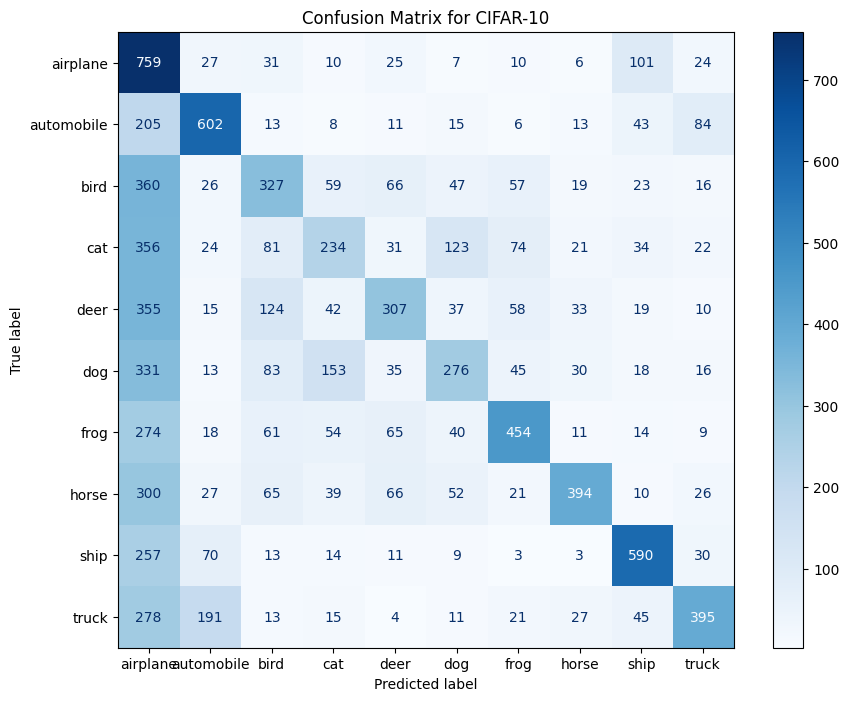

In [39]:

# Evaluate Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_sk.argmax(axis=1))
print(f"Accuracy: {accuracy:.2f}")

# evaluate F1-Score 
f1 = f1_score(y_test, y_pred_sk, average='weighted')
print(f"F1-Score: {f1:.2f}")

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_sk.argmax(axis=1))

fig, ax = plt.subplots(figsize=(10, 8))  # Properly create the figure and axis
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix for CIFAR-10")
plt.show()

#### **5.2. TensorFlow/Keras.**

Accuracy: 0.53
F1-Score: 0.53


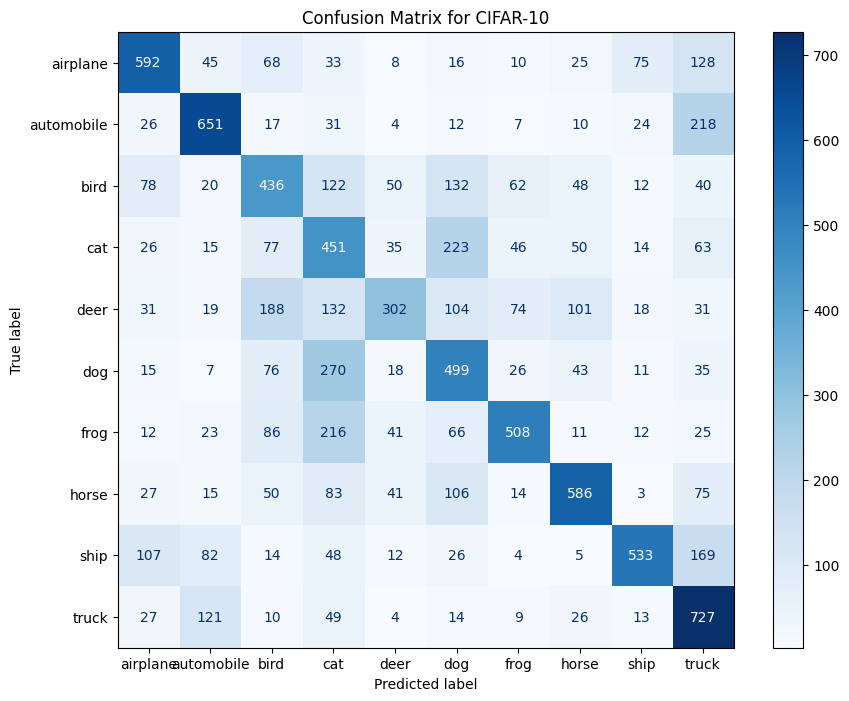

In [36]:
# Evaluate Accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred_tf.argmax(axis=1))
print(f"Accuracy: {accuracy:.2f}")

# evaluate F1-Score 
f1 = f1_score(y_test.argmax(axis=1), y_pred_tf.argmax(axis=1), average='weighted')
print(f"F1-Score: {f1:.2f}")

# Calculate Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))  # Properly create the figure and axis
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix for CIFAR-10")
plt.show()

#### **5.3. Pytorch.**

Accuracy: 0.5727
F1 Score: 0.5727


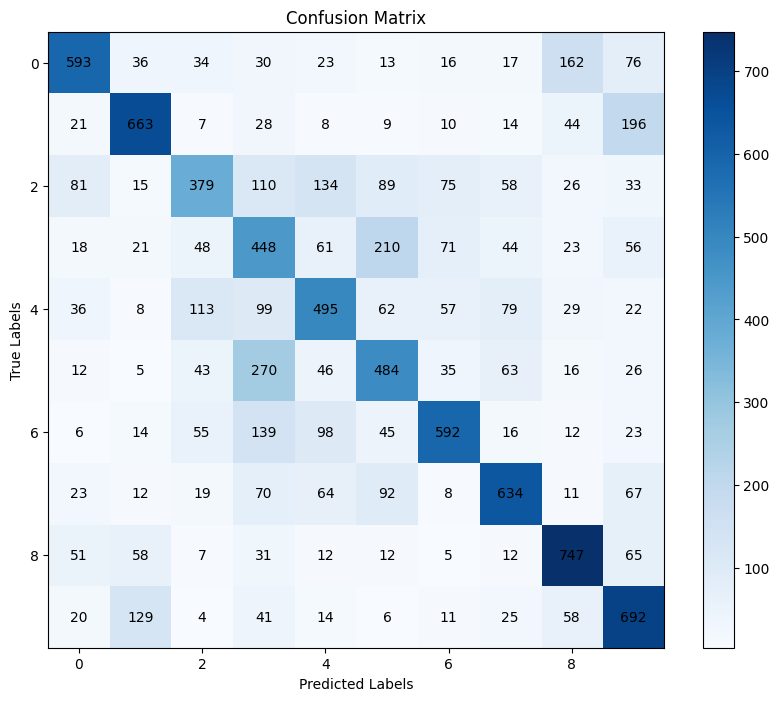

In [27]:
import torchmetrics

accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)
f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=10)

accuracy = accuracy_metric(predicted, actual)
f1 = f1_metric(predicted, actual)

print(f"Accuracy: {accuracy.item():.4f}")
print(f"F1 Score: {f1.item():.4f}")

confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=10)
conf_matrix = confmat(predicted, actual)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(conf_matrix.cpu().numpy(), cmap='Blues')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = ax.text(j, i, int(conf_matrix[i, j].item()),
                       ha="center", va="center", color="black")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.colorbar(im)
plt.show()
